# Method4 DCT based DOST + Huffman encoding

## Import Libraries

In [18]:
import mne
import numpy as np
from scipy.fft import fft,fftshift
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter
from scipy.signal import freqz
from scipy import signal
from scipy.fftpack import fft, dct, idct
from itertools import islice 
import pandas as pd
import os

## Preprocessing

### Data loading

In [2]:
acc = pd.read_csv('ACC.csv')
acc = acc.iloc[1:]
acc.columns = ['column1','column2','column3']
np.savetxt('acc.txt',acc)



acc_c1 = acc["column1"]
acc_c2 = acc["column2"]
acc_c3 = acc["column3"]
acc_array_c1 = acc_c1.to_numpy() #save the data into an ndarray
acc_array_c2 = acc_c2.to_numpy()
acc_array_c3 = acc_c3.to_numpy()
acc_array_c1.shape

acc_array_c1 = acc_array_c1[0:66000]  # Remove the signal in first 3minutes and last 5minutes
acc_array_c2 = acc_array_c2[0:66000]
acc_array_c3 = acc_array_c3[0:66000]

sampling_freq = 1/32
N = acc_array_c1.size

xf = np.linspace(-N*sampling_freq/2, N*sampling_freq/2,  N)


index = np.linspace(0, round((N-1)*sampling_freq,4), N)



### Butterworth Filter to denoising

In [3]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

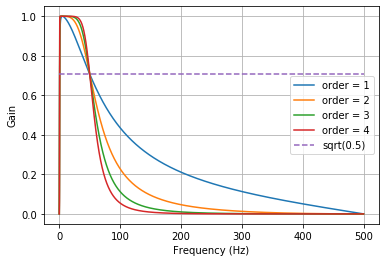

In [4]:
from scipy.signal import freqz
from scipy import signal
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1000.0
lowcut = 0.5
highcut = 50.0

# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [1, 2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [5]:
y1 = butter_bandpass_filter(acc_array_c1, lowcut, highcut, fs, order=2)
y2 = butter_bandpass_filter(acc_array_c2, lowcut, highcut, fs, order=2)
y3 = butter_bandpass_filter(acc_array_c3, lowcut, highcut, fs, order=2)

In [6]:
resampled_signal1 = y1
resampled_signal2 = y2
resampled_signal3 = y3

In [7]:
np.savetxt('processed_acc_col1.txt',resampled_signal1)
np.savetxt('processed_acc_col2.txt',resampled_signal2)
np.savetxt('processed_acc_col3.txt',resampled_signal3)

In [8]:
rounded_signal1 = np.around(resampled_signal1)
rounded_signal2 = np.around(resampled_signal2)
rounded_signal3 = np.around(resampled_signal3)

## Transformation --- DCT based DOST 

In [9]:
from scipy.fftpack import fft, dct
aN1 = dct(rounded_signal1, type = 2, norm = 'ortho')
aN2 = dct(rounded_signal2, type = 2, norm = 'ortho')
aN3 = dct(rounded_signal3, type = 2, norm = 'ortho')

In [10]:
def return_N(target):
    if target > 1:
        for i in range(1, int(target)):
            if (2 ** i >= target):
                return i-1
    else:
        return 1


In [11]:
from itertools import islice 
split_list = [1]
for i in range(0,return_N(aN1.size)):
    split_list.append(2 ** i)
temp1 = iter(aN1) 
res1 = [list(islice(temp1, 0, ele)) for ele in split_list]
temp2 = iter(aN2) 
res2 = [list(islice(temp2, 0, ele)) for ele in split_list]
temp3 = iter(aN3) 
res3 = [list(islice(temp3, 0, ele)) for ele in split_list]

In [12]:
from scipy.fftpack import fft, dct, idct
cN_idct1 = [list(idct(res1[0], type = 2, norm = 'ortho' )), list(idct(res1[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res1)):
    cN_idct1.append(list(idct(res1[k], type = 2, norm = 'ortho' )))
cN_idct2 = [list(idct(res2[0], type = 2, norm = 'ortho' )), list(idct(res2[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res2)):
    cN_idct2.append(list(idct(res2[k], type = 2, norm = 'ortho' )))
cN_idct3 = [list(idct(res3[0], type = 2, norm = 'ortho' )), list(idct(res3[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res3)):
    cN_idct3.append(list(idct(res3[k], type = 2, norm = 'ortho' )))

In [13]:
all_numbers1 = []
for i in cN_idct1:
    for j in i:
        all_numbers1.append(j)
all_numbers2 = []
for i in cN_idct2:
    for j in i:
        all_numbers2.append(j)
all_numbers3 = []
for i in cN_idct3:
    for j in i:
        all_numbers3.append(j)

In [14]:
all_numbers1 = np.asarray(all_numbers1)
all_numbers2 = np.asarray(all_numbers2)
all_numbers3 = np.asarray(all_numbers3)

In [15]:
int_cN1 = np.round(all_numbers1,3)
int_cN2 = np.round(all_numbers2,3)
int_cN3 = np.round(all_numbers3,3)

In [16]:
np.savetxt('int_cN1.txt',int_cN1, fmt='%.3f')
np.savetxt('int_cN2.txt',int_cN2, fmt='%.3f')
np.savetxt('int_cN3.txt',int_cN3,fmt='%.3f')

## Huffman Coding

### INSTRUCTION ON HOW TO COMPRESS THE DATA BY HUFFMAN CODING


(I used the package "tcmpr 0.2" and "pyhuff 1.1". These two packages provided the same compression result. So here, we just use "tcmpr 0.2")

1. Open your termial or git bash, enter "pip install tcmpr" to install the "tcmpr 0.2" package
2. Enter the directory which include the file you want to compress OR copy the path of the file you want to compress
3. Enter "tcmpr filename.txt" / "tcmpr filepath" to compress the file
4. Find the compressed file in the same directory of the original file

In [19]:
# Do Huffman encoding based on the instruction above 
# or run this trunk if this scratch locates in the same directory with the signal you want to encode
os.system('tcmpr int_cN1.txt')
os.system('tcmpr int_cN2.txt')
os.system('tcmpr int_cN3.txt')

0

## Reconstruction

In [20]:
os.system('tcmpr -d int_cN1.txt.huffman')
os.system('tcmpr -d int_cN2.txt.huffman')
os.system('tcmpr -d int_cN3.txt.huffman')
decoded_data1 = np.loadtxt(fname = "int_cN1.txt")
decoded_data2 = np.loadtxt(fname = "int_cN2.txt")
decoded_data3 = np.loadtxt(fname = "int_cN3.txt")

In [21]:
recover_signal1 = decoded_data1
recover_signal2 = decoded_data2
recover_signal3 = decoded_data3
recover_signal1 = list(recover_signal1)
recover_signal2 = list(recover_signal2)
recover_signal3 = list(recover_signal3)
len(recover_signal1)

65536

In [22]:
split_list = [1]
for i in range(0,return_N(len(recover_signal1))+1):
    split_list.append(2 ** i)
temp_recovered1 = iter(recover_signal1) 
res_recovered1 = [list(islice(temp_recovered1, 0, ele)) for ele in split_list]
temp_recovered2 = iter(recover_signal2) 
res_recovered2 = [list(islice(temp_recovered2, 0, ele)) for ele in split_list] 
temp_recovered3 = iter(recover_signal3) 
res_recovered3 = [list(islice(temp_recovered3, 0, ele)) for ele in split_list] 

In [23]:
recover_dct1 = [list(dct(res_recovered1[0], type = 2, norm = 'ortho' )), list(dct(res_recovered1[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered1)):
    recover_dct1.append(list(dct(res_recovered1[k], type = 2, norm = 'ortho' )))
recover_dct2 = [list(dct(res_recovered2[0], type = 2, norm = 'ortho' )), list(dct(res_recovered2[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered2)):
    recover_dct2.append(list(dct(res_recovered2[k], type = 2, norm = 'ortho' )))
recover_dct3 = [list(dct(res_recovered3[0], type = 2, norm = 'ortho' )), list(dct(res_recovered3[1], type = 2, norm = 'ortho' ))]
for k in range(2,len(res_recovered3)):
    recover_dct3.append(list(dct(res_recovered3[k], type = 2, norm = 'ortho' )))

In [24]:
all_recover1 = []
for i in recover_dct1:
    for j in i:
        all_recover1.append(j)
all_recover2 = []
for i in recover_dct2:
    for j in i:
        all_recover2.append(j)
all_recover3 = []
for i in recover_dct3:
    for j in i:
        all_recover3.append(j)


In [25]:
aN_recover1 = idct(all_recover1, type = 2, norm = 'ortho')
aN_recover2 = idct(all_recover2, type = 2, norm = 'ortho')
aN_recover3 = idct(all_recover3, type = 2, norm = 'ortho')

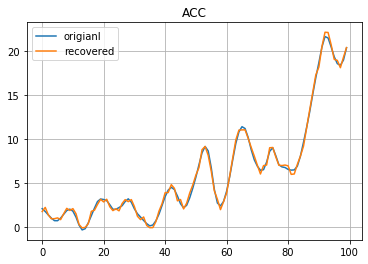

In [26]:
plt.plot(signal.resample(y1, len(aN_recover1))[31000:31100], label = "origianl")
plt.plot(aN_recover1[31000:31100], label = "recovered")
plt.legend()
plt.title('ACC')
plt.grid()
plt.show()

In [27]:
#resampled_signal_shorter = resampled_signal1[:len(aN_recover1)] 
resampled_signal_shorter1 = signal.resample(y1, len(aN_recover1))
from sklearn.metrics import mean_squared_error
from math import sqrt

def PRD_calculation(original_signal, compressed_signal):
    PRD = sqrt(sum((original_signal-compressed_signal)**2)/(sum(original_signal**2)))
    return PRD

PRD = PRD_calculation(resampled_signal_shorter1, aN_recover1)
print("The PRD is {}%".format(round(PRD*100,3)))

The PRD is 3.16%
